# 

In [1]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [2]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [3]:
import numpy as np
import h5py

In [4]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

In [10]:
root = DATA_ROOT/"tmp_data/multicoil_train";
fils = list(root.glob("*.h5"));



In [11]:
hf = h5py.File(fils[0]);

In [12]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXT1POST', 'max': 0.0012707645406897644, 'norm': 0.28436865057951644, 'patient_id': '5a7cc20c6986136e4cc1437e94f522e7f1cc2cd49356393a6d28f30634d680e7'}


In [13]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 16, 640, 320)


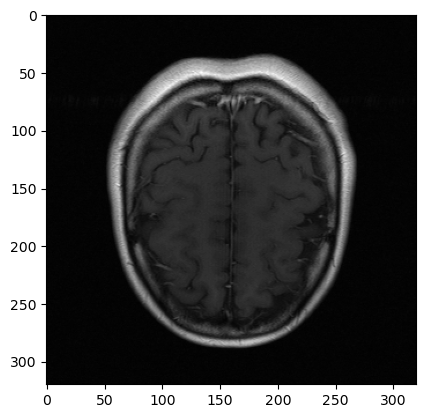

In [14]:
data= hf['reconstruction_rss'][()];
plt.imshow(data[8], cmap='gray')

In [34]:
slice_kspace = volume_kspace[10]; # Choosing the 20-th slice of this volume

In [35]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

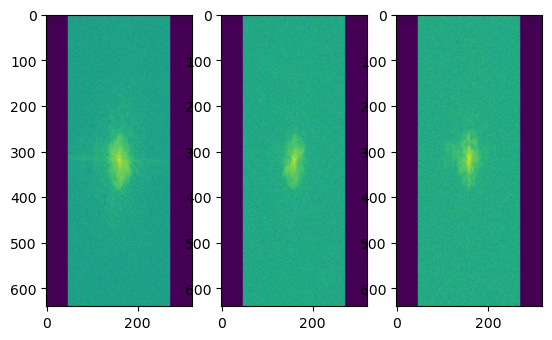

In [36]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10

In [37]:
import fastmri
from fastmri.data import transforms as T

In [39]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image);  

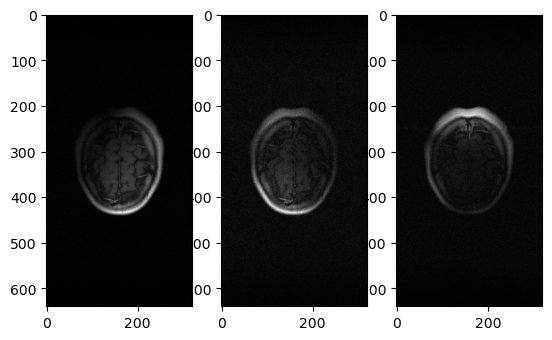

In [40]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

In [41]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

tensor([[7.6981e-06, 8.8717e-06, 1.2944e-05,  ..., 1.1745e-05, 8.4830e-06,
         1.3284e-05],
        [1.1445e-05, 1.1410e-05, 1.0518e-05,  ..., 1.1905e-05, 1.5015e-05,
         1.3313e-05],
        [1.0004e-05, 1.0896e-05, 9.9689e-06,  ..., 1.0574e-05, 9.8600e-06,
         1.2317e-05],
        ...,
        [1.3237e-05, 1.2113e-05, 1.0320e-05,  ..., 1.3551e-05, 1.1035e-05,
         1.2035e-05],
        [1.2385e-05, 1.1552e-05, 9.4317e-06,  ..., 9.3878e-06, 1.1531e-05,
         1.1102e-05],
        [9.7589e-06, 1.2961e-05, 1.2313e-05,  ..., 1.1039e-05, 1.1552e-05,
         9.6791e-06]])

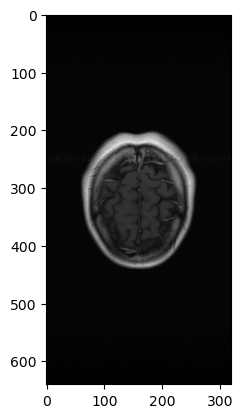

In [42]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

In [43]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [44]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

In [45]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

tensor([[5.0605e-06, 3.3306e-06, 4.8467e-06,  ..., 3.6708e-06, 4.5473e-06,
         4.4577e-06],
        [5.5387e-06, 4.4132e-06, 3.2310e-06,  ..., 5.0233e-06, 5.6643e-06,
         5.0430e-06],
        [3.6618e-06, 3.5935e-06, 3.0920e-06,  ..., 4.9521e-06, 4.0431e-06,
         4.8489e-06],
        ...,
        [3.1309e-06, 3.9821e-06, 3.7872e-06,  ..., 4.6218e-06, 4.7811e-06,
         4.4262e-06],
        [3.9038e-06, 3.6626e-06, 4.4042e-06,  ..., 4.6594e-06, 4.6258e-06,
         4.2812e-06],
        [4.4378e-06, 3.8284e-06, 4.2214e-06,  ..., 4.2009e-06, 3.8927e-06,
         3.6739e-06]])

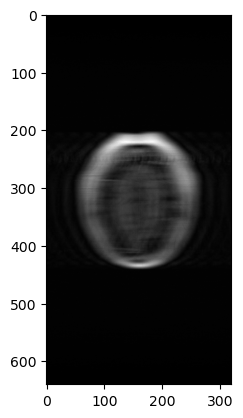

In [46]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')